<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/HUPV/notebooks/cv09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9. Cvičenie - Rekurentné siete

Na dnešnom cvičení si precvičíme prácu s rekurentnými sieťami. Vytvoríme si mierne umelý príklad, v ktorom skonštruujeme veľké číslo zo sekvencie MNIST čísel a vrátime honotu po aplikácii modula nejakým číslom (ideálne prvočíslo nad 10).

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [ ]:
import numpy as np
x = np.array(mnist.data.astype('float32')/255)
labels = np.array(mnist.target.astype('int64'))

x_train = x[:50000]
labels_train = labels[:50000]
x_val = x[50000:60000]
labels_val = labels[50000:60000]
x_test = x[60000:]
labels_test = labels[60000:]

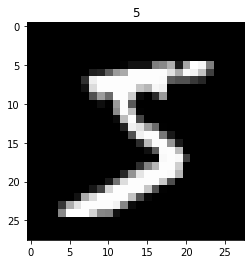

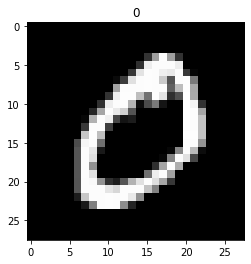

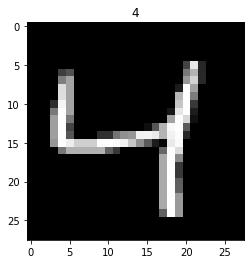

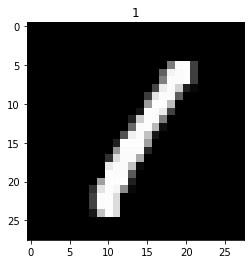

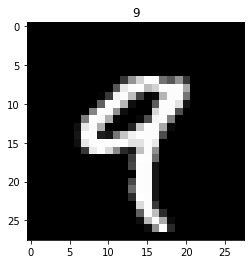

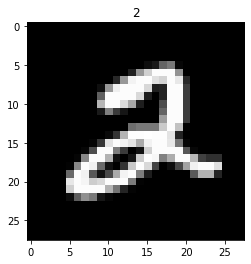

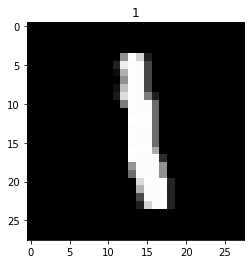

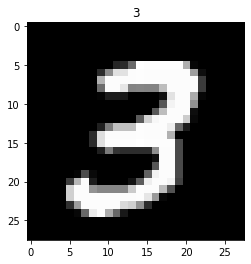

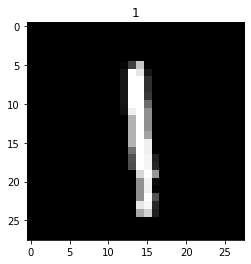

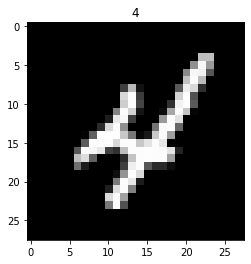

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

for i in range(10):
  plt.imshow(np.reshape(x[i, :],(28,28)), cmap='gray')
  plt.title(labels[i])
  plt.show()

## GRU vrstva

V pytorchi GRU vrstva očakáva na vstupe tenzor 3. rádu, kde jednolivé dimenzie sú: dĺžka sekvencie, batch, features. Teda v prípade ak chceme mať na vstupe len jeden element bude mať tvar $1 \times 1 \times f$, ak by sme mali sekvenciu dĺžky $n_t$ tak to bude $n_t \times 1 \times f$. Samozrjeme ak to budeme mať celý batch s $n_b$ prvkami bude vstup tvaru $n_t \times n_b \times f$.

GRU okrem toho na vstupe vyžaduje ešte skryté stavy ako tenzor druhého rádu s tvarom $d \times n_b \times h$, kde $h$ je veľkosť skrytého stavu a $d$ je počet GRU vrstiev.

Je možné pridať GRU aj keyword arguement `batch_first=True` ten prehodí prvé dve dimenzie, takže vstup bude tvaru $n_b \times n_t \times f$, hidden ostane v tvare $d \times n_b \times h$.

V ďalšej práci s GRU budem používať `batch_first=True` keďže je to pohodlnejšie.

In [ ]:
import torch
from torch.nn import GRU

gru = GRU(32, 64)


# Môžeme do gru hodiť po jednom príklade
x = torch.rand(1, 1, 32)
h = torch.rand(1, 1, 64)

out, h = gru(x, h)

print(out.size())
print(h.size())


# Môžeme tiež použiť batch size 16
x = torch.rand(1, 16, 32)
h = torch.rand(1, 16, 64)

out, h = gru(x, h)

print(out.size())
print(h.size())


# Na vstupe môžeme mať aj dlhšiu sekvenciu
x = torch.rand(4, 16, 32)
# Skrytý stav však stále bude mať na vstupe 1
h = torch.rand(1, 16, 64)

out, h = gru(x, h)

print(out.size())
print(h.size())


# Môžeme mať aj viac GRU vrstvie za sebou

gru2 = GRU(32, 64, num_layers=2)
x = torch.rand(4, 16, 32)
h = torch.rand(2, 16, 64)

out, h = gru2(x, h)

print(out.size())
print(h.size())


# Ak použijeme batch_first=True tak potrebujeme iné tvary

gru_bf = GRU(32, 64, num_layers=2, batch_first=True)
x = torch.rand(16, 4, 32)
h = torch.rand(2, 16, 64)

out, h = gru_bf(x, h)

print(out.size())
print(h.size())

torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 16, 64])
torch.Size([1, 16, 64])
torch.Size([4, 16, 64])
torch.Size([1, 16, 64])
torch.Size([4, 16, 64])
torch.Size([2, 16, 64])
torch.Size([16, 4, 64])
torch.Size([2, 16, 64])


## Aplikácia iných vrstiev v sekvencii

Problém samozrejme bude ak by sme pred GRU vrstvou chceli najprv aplikovať konvolučné vrstvy.

![GRU](https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/ntb_images/GRU_model.png)

To je problém lebo prvá Conv2d očakáva na vstupe tvar $n_b \times 1 \times h \times w$, ale mi budeme mať sekvenciu $n_t \times n_b \times 1 \times h \times w$. Preto ak chceme aplikovať model, tak musíme najprv vstup upraviť do tvaru $n_tn_b \times 1 \times h \times w$. Na výstupe potom budeme mať po globálnom pooling $n_tn_b \times f_{out}$. A to budeme musieť opäť prekonvertovať na $n_t \times n_b \times f$.

Pre tento účel si napíšeme vlastný modul, ktorý bude obsahovať všetky vrstvy. Ako jediný parameter konštruktora bude počet výstupných tried. To bude nejaké prvočíslo ideálne väčšie ako 10. Cieľom našej siete bude prečítať posutpne číslo zľava doprava ako by bolo zapísané a potom spočítať jeho modulo našim prvočíslom.

Samozrejme si môžete sieť upraviť aby mala aj iný počet kanálov na vnútorných vrstvách.

In [ ]:
from torch.nn import Module, Conv2d, Linear, GRU, BatchNorm2d, BatchNorm1d

class ConvGRUNet(Module):
  def __init__(self, n_out):
    super(ConvGRUNet, self).__init__()

    self.conv1 = Conv2d(1, 32, 5)
    self.conv2 = Conv2d(32, 32, 5)
    self.conv3 = Conv2d(32, 32, 5)
    self.conv4 = Conv2d(32, 64, 5)

    self.bn1 = BatchNorm2d(32)
    self.bn2 = BatchNorm2d(32)
    self.bn3 = BatchNorm2d(32)
    self.bn4 = BatchNorm2d(64)

    self.bn5 = BatchNorm1d(64)

    self.gru = GRU(64, 64, batch_first=True)
    self.linear = Linear(64, n_out)
    self.n_out = n_out


  def forward(self, x, h):
    s = x.size()
    x = x.reshape(s[0] * s[1], 1, 28, 28)

    x = self.conv1(x)
    x = torch.nn.functional.elu(x)
    x = self.bn1(x)
    x = self.conv2(x)
    x = torch.nn.functional.elu(x)
    x = self.bn2(x)
    x = self.conv3(x)
    x = torch.nn.functional.elu(x)
    x = self.bn3(x)
    x = self.conv4(x)
    x = torch.nn.functional.elu(x)
    x = self.bn4(x)

    x = torch.mean(x, dim=-1)
    x = torch.mean(x, dim=-1)

    x = x.reshape(s[0], s[1], 64)
    x, h = self.gru(x, h)
    x = x.reshape(s[0] * s[1], 64)
    x = self.bn5(x)
    x = self.linear(x)
    x = x.reshape(s[0], s[1], self.n_out)

    return x, h

net = ConvGRUNet(13)
x = torch.rand(16,10,28,28)
h = torch.rand(1, 16, 64)

out, out_h = net(x, h)
print(out.size())
print(out_h.size())

torch.Size([16, 10, 13])
torch.Size([1, 16, 64])


Môžeme si vybrať ako budeme trénovať túto sieť. Na vstupe budeme mať sekvenciu obrázkov tvaru $n_b \times n_t \times 1 \times 28 \times 28$. Tým že robíme reshape by sme ale mohli mať kľudne aj  $n_b \times n_t \times 28 \times 28$, alebo $n_b \times n_t \times 784$.

Na výstupe máme dve možnosti. Buď budeme sledovať len výstup na konci sekvencie a z neho rátať loss, alebo budeme trénovať sieť na všetky vstupy. Najprv otestujeme druhý prístup:

![GRU Multiloss](https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/ntb_images/GRU_multi_loss.png)

Na to si najprv ale budeme musieť napísať dataset aby nám dával sekvencie. Tu si teda v `__getitem__` budeme generovať vždy po páre vstupu a výstupu v tvare $n_t \times 28 \times 28$ a $n_t$. Ako vstup budeme pridávať postupne náhodné obrázky čísiel z MNISTu a ako výsup bude vždy modulo nejakým zvoleným číslom ak by sme zobrali vybratú sekvenciu a prečítali ju zľava do prava ako jedno číslo.

Náš dataset má v konštruktore následovné argumenty:

`x` - Numpy array veľkosti $n \times 784$ s MNIST obrázkami

`labels` - Numpy array s labelmi obrázkov

`modulo` - čislo ktorým budeme robiť modulo

`seq_length` - dĺžka štandardnej sekvencie

`length` - počet prvkov v jednej epoche, keďže čísla vyberáme náhodne

Metóda `__getitem__` generuje prvky v tvare $n_t \times 28 \times 28$ a $n_t$. Ak by sme nepoužili `batch_first=True` v GRU, tak pri štandardnom použití data loaderu by sa tieto prvky spojili do batch cez prvú dimenziu. To by bol problém, lebo potom by bolo napr. x tvaru $n_b \times n_t \times 28 \times 28$ a nie $n_t \times n_b \times 28 \times 28$. V takom prípade by bolo nutné v DataLoaderi pridať ešte funkciu collate ktorá dáta spojí tak ako chceme.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class SeqDataset(Dataset):
  def __init__(self, x, labels, modulo, seq_length, length=10000):
    super(SeqDataset).__init__()
    self.x = x
    self.num_items = len(x)
    self.labels = labels
    self.modulo = modulo
    self.seq_length = seq_length
    self.length = length

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    xs = np.empty([self.seq_length, 28, 28], dtype=np.float32)
    ys = np.empty(self.seq_length, dtype=np.int64)

    # doimplementujte
    ...
    return torch.from_numpy(xs), torch.from_numpy(ys)

dataset = SeqDataset(x_train, labels_train, 13, 10, length=32)
loader = DataLoader(dataset, batch_size=16)

# Ak by sme v GRU vrstve nepoužili batch_first=True, tak by sme museli spraviť niečo takéto.
# def collate_fn(items):
#   xs = [x[0] for x in items]
#   ys = [x[1] for x in items]

#   xs = torch.stack(xs, dim=1)
#   ys = torch.stack(ys, dim=1)
#   return xs, ys
#
# loader = DataLoader(dataset, batch_size=16, collate_fn=collate_fn)

for item in loader:
  x, y = item
  print(x.size())
  print(y.size())

torch.Size([16, 10, 28, 28])
torch.Size([16, 10])
torch.Size([16, 10, 28, 28])
torch.Size([16, 10])


Dataset si zobrazíme.

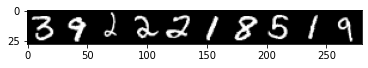

tensor([ 3,  0,  2,  9,  1, 11,  1,  2,  8, 11])


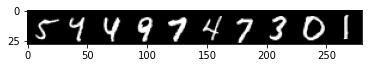

tensor([ 5,  2, 11,  2,  1,  1,  4,  4,  1, 11])


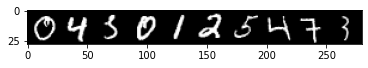

tensor([ 0,  4,  4,  1, 11,  8,  7,  9,  6, 11])


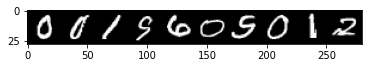

tensor([ 0,  0,  1,  6,  1, 10,  1, 10, 10, 11])


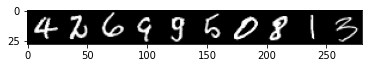

tensor([ 4,  3, 10,  5,  7, 10,  9,  7,  6, 11])


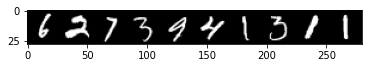

tensor([ 6, 10,  3,  7,  1,  1, 11,  9,  0,  1])


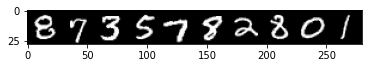

tensor([ 8,  9,  2, 12, 10,  4,  3, 12,  3,  5])


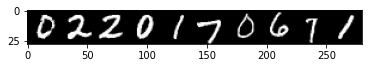

tensor([ 0,  2,  9, 12,  4,  8,  2,  0,  7,  6])


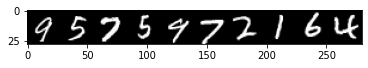

tensor([9, 4, 8, 7, 1, 4, 3, 5, 4, 5])


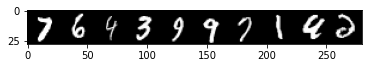

tensor([ 7, 11, 10, 12, 12, 12, 10, 10,  5,  0])


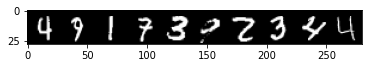

tensor([ 4, 10, 10,  3,  7,  1, 12,  6, 12,  7])


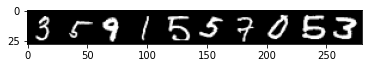

tensor([ 3,  9,  8,  3,  9,  4,  8,  2, 12,  6])


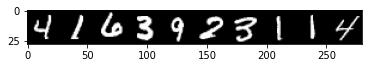

tensor([ 4,  2,  0,  3,  0,  2, 10, 10, 10,  0])


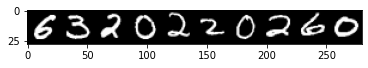

tensor([ 6, 11,  8,  2,  9,  1, 10, 11, 12,  3])


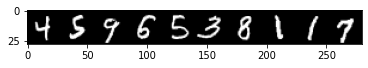

tensor([ 4,  6,  4,  7, 10, 12, 11,  7,  6,  2])


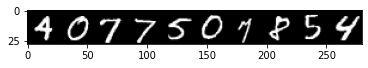

tensor([4, 1, 4, 8, 7, 5, 5, 6, 0, 4])


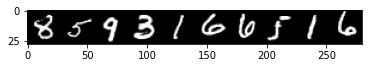

tensor([ 8,  7,  1,  0,  1,  3, 10,  1, 11, 12])


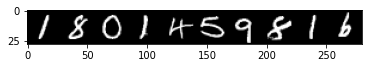

tensor([ 1,  5, 11,  7,  9,  4, 10,  4,  2,  0])


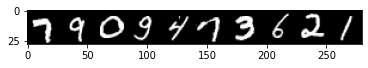

tensor([ 7,  1, 10,  5,  2,  1,  0,  6, 10, 10])


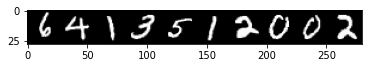

tensor([ 6, 12,  4,  4,  6,  9,  1, 10,  9,  1])


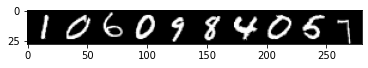

tensor([ 1, 10,  2,  7,  1,  5,  2,  7, 10,  3])


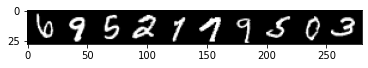

tensor([ 6,  4,  6, 10,  3, 11,  2, 12,  3,  7])


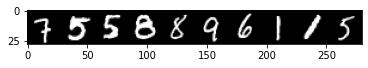

tensor([ 7, 10,  1,  5,  6,  4,  7,  6,  9,  4])


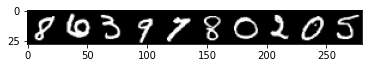

tensor([ 8,  8,  5,  7, 12, 11,  6, 10,  9,  4])


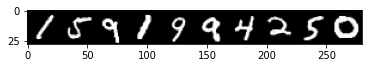

tensor([ 1,  2,  3,  5,  7,  1,  1, 12,  8,  2])


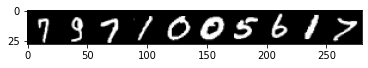

tensor([ 7,  1,  4,  2,  7,  5,  3, 10, 10,  3])


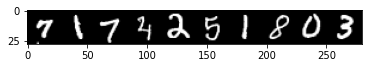

tensor([ 7,  6,  2, 11,  8,  7,  6,  3,  4,  4])


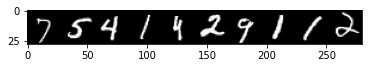

tensor([ 7, 10,  0,  1,  1, 12, 12,  4,  2,  9])


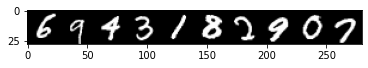

tensor([ 6,  4,  5,  1, 11,  1, 12, 12,  3, 11])


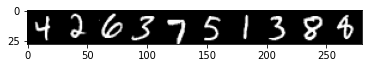

tensor([ 4,  3, 10, 12, 10,  1, 11,  9,  7,  0])


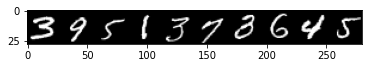

tensor([ 3,  0,  5, 12,  6,  2, 10,  2, 11, 11])


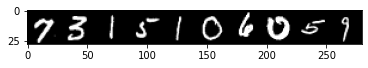

tensor([7, 8, 3, 9, 0, 0, 6, 8, 7, 1])


In [ ]:
dataset = SeqDataset(x_train, labels_train, 13, 10, length=32)
loader = DataLoader(dataset, batch_size=1)

for item in loader:
  x, y = item
  x = x[0].numpy()
  img = np.concatenate(x, axis=1)
  plt.imshow(img, cmap='gray')
  plt.show()
  print(y[0])

## Tréning so stratou po každom výstupe

Teraz môžme pristúpiť k tréningu. Opäť si vytvoríme jednoduchý loop. Pri dataloaderi navyše použijeme keyword `drop_last=True` týmto sa neaplikuje posledný batch ktorý by nenaplnil celú batch size. Keďže generujeme poradie náhodne tak to ani nemá zmysel.

In [ ]:
modulo = 13
seq_length = 6
batch_size = 16


dataset_train = SeqDataset(x_train, labels_train, modulo, seq_length)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, drop_last=True)

dataset_val = SeqDataset(x_val, labels_val, modulo, seq_length, length=1000)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, drop_last=True)

model = ConvGRUNet(modulo).cuda()
print(model)

ce_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for e in range(10):
  model.train()
  for i, samples in enumerate(dataloader_train):
    x = samples[0].cuda()
    y = samples[1].cuda()
    optimizer.zero_grad()

    h = torch.zeros(1, batch_size, 64, dtype=torch.float).cuda()
    out, h_out = model(x, h)

    out = out.reshape(-1, modulo)
    y = y.reshape(-1)
    loss = ce_loss(out, y)

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      print("Loss at epoch: {} step {}: {}".format(e, i, loss.item()))

  model.eval()
  with torch.no_grad():
    val_losses = []
    correct = 0
    total = 0
    for i, samples in enumerate(dataloader_val):
      x = samples[0].cuda()
      y = samples[1].cuda()

      h = torch.zeros(1, batch_size, 64, dtype=torch.float).cuda()
      out, h_out = model(x, h)

      out = out.reshape(-1, modulo)
      y = y.reshape(-1)
      loss = ce_loss(out, y)

      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      val_losses.append(loss.item())
      total += len(y)

    print("Val loss at epoch {}: {}".format(e, np.mean(val_losses)))
    print("Val acc at epoch {}: {}".format(e, correct / total))

ConvGRUNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru): GRU(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=13, bias=True)
)
Loss at epoch: 0 step 0: 2.7444255352020264
Loss at epoch: 0 step 100: 2.501591444015503
Loss at epoch: 0 step 200: 2.4518845081329346
Loss at epoch: 0 step 300: 2.376197099685669
Loss at epoch: 0

## Inferencia celej sekvencie

Model si otestujeme. Na vstup môžeme dávať celú sekvenciu.

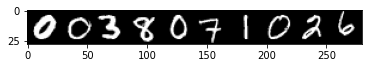

GT:  tensor([ 0,  0,  3, 12,  3, 11,  7,  5,  0,  6], device='cuda:0')
Output tensor([ 0,  0,  3, 12,  3, 11,  7,  5,  0,  6], device='cuda:0')


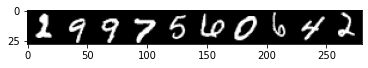

GT:  tensor([ 2,  3,  0,  7, 10,  2,  7, 11, 10, 11], device='cuda:0')
Output tensor([ 2,  3,  0,  7, 10,  2,  7, 11, 10, 11], device='cuda:0')


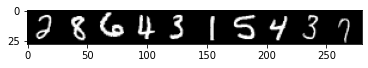

GT:  tensor([ 2,  2,  0,  4,  4,  2, 12,  7,  8,  9], device='cuda:0')
Output tensor([ 2,  2,  0,  4,  4,  2, 12,  7,  8,  9], device='cuda:0')


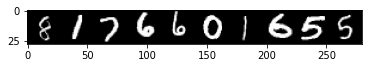

GT:  tensor([ 8,  3, 11, 12,  9, 12,  4,  7, 10,  1], device='cuda:0')
Output tensor([ 8,  3, 11, 12,  9, 12,  4,  7, 10,  1], device='cuda:0')


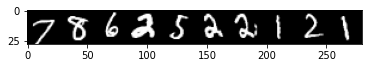

GT:  tensor([ 7,  0,  6, 10,  1, 12,  5, 12,  5, 12], device='cuda:0')
Output tensor([ 7,  0,  6, 10,  1, 12,  5, 12,  5, 12], device='cuda:0')


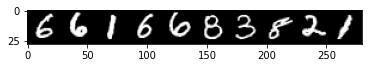

GT:  tensor([ 6,  1, 11, 12,  9,  7,  8, 10, 11,  7], device='cuda:0')
Output tensor([ 6,  1, 11, 12,  9,  7,  8, 10, 11,  9], device='cuda:0')


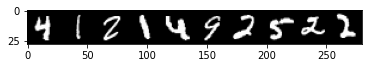

GT:  tensor([ 4,  2,  9,  0,  4, 10, 11, 11,  8,  4], device='cuda:0')
Output tensor([ 4,  2,  9,  0,  4, 10, 11, 11,  8,  4], device='cuda:0')


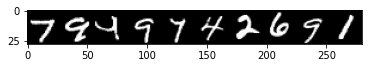

GT:  tensor([ 7,  1,  1,  6,  2, 11,  8,  8, 11,  7], device='cuda:0')
Output tensor([ 7,  1,  1,  6,  2, 11,  8,  8, 11,  7], device='cuda:0')


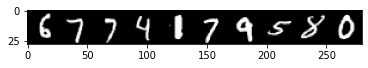

GT:  tensor([ 6,  2,  1,  1, 11,  0,  9,  4,  9, 12], device='cuda:0')
Output tensor([ 6,  2,  1,  1, 11,  0,  9,  4,  9, 12], device='cuda:0')


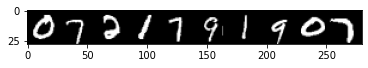

GT:  tensor([0, 7, 7, 6, 2, 3, 5, 7, 5, 5], device='cuda:0')
Output tensor([0, 7, 7, 6, 2, 3, 5, 7, 5, 5], device='cuda:0')


In [ ]:
modulo = 13
seq_length = 10

dataset = SeqDataset(x_test, labels_test, modulo, seq_length, length=10)
loader = DataLoader(dataset, batch_size=1)

model.eval()

for samples in loader:
  x = samples[0].cuda()
  y = samples[1].cuda()

  h = torch.zeros(1, 1, 64).cuda()
  out, h_out = model(x, h)
  img = np.concatenate(x[0].cpu().numpy(), axis=1)
  plt.imshow(img, cmap='gray')
  plt.show()
  print("GT: ", y[0])
  print("Output", torch.argmax(out[0], dim=-1))

## Úloha 1 - Inferencia po častiach

Inferenciu môžeme robiť aj po častiach. Napíšte kód v ktorom budete postupne náhodne vyberať obrázky čísiel z MNISTu a dávať ich ako vstup do siete vo for cykle. Nezabudnite, že na začiatok sekvencie si musíte nainicializovať vektor skytého stavu. Následne sieť vyhodí výstup siete a nový vektor skrytého stavu, ktorý použijete v ďalšej iterácii.

Pri výpise vypíšte zadané číslo vždy po každej pridanej cifre. Vypíšte pre ňu aj správne modulo a modulo získané ako výstup zo siete. Môžete tiež vykresliť sekvenciu obrázkov podobne ako v predchádzajúcom príklade. Môžete sa pritom inšpirovať pôvodným výstupom ktorý som dole nechal.

Starting new sequence!


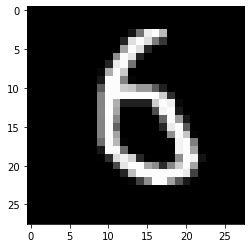

Val:  6 Modulo:  6 Out:  tensor([6], device='cuda:0')


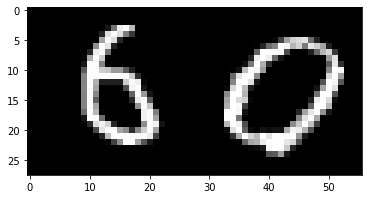

Val:  60 Modulo:  8 Out:  tensor([8], device='cuda:0')


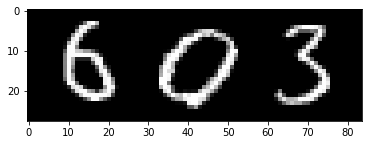

Val:  603 Modulo:  5 Out:  tensor([5], device='cuda:0')


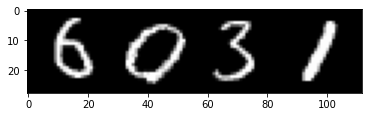

Val:  6031 Modulo:  12 Out:  tensor([12], device='cuda:0')


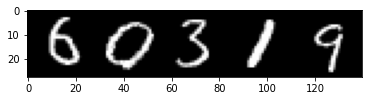

Val:  60319 Modulo:  12 Out:  tensor([12], device='cuda:0')


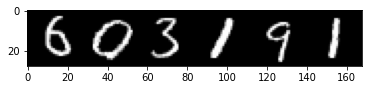

Val:  603191 Modulo:  4 Out:  tensor([4], device='cuda:0')


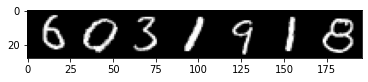

Val:  6031918 Modulo:  9 Out:  tensor([9], device='cuda:0')


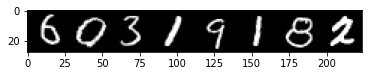

Val:  60319182 Modulo:  1 Out:  tensor([1], device='cuda:0')


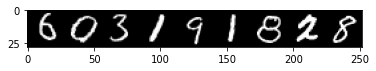

Val:  603191828 Modulo:  5 Out:  tensor([5], device='cuda:0')


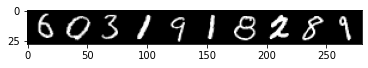

Val:  6031918289 Modulo:  7 Out:  tensor([12], device='cuda:0')
Starting new sequence!


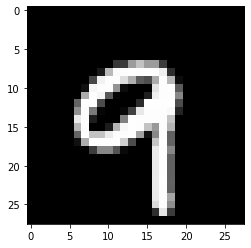

Val:  9 Modulo:  9 Out:  tensor([9], device='cuda:0')


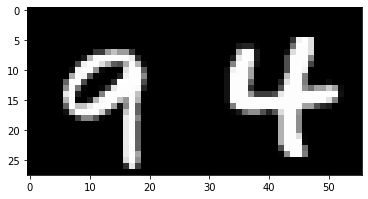

Val:  94 Modulo:  3 Out:  tensor([3], device='cuda:0')


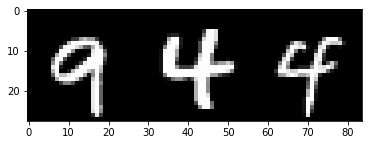

Val:  944 Modulo:  8 Out:  tensor([8], device='cuda:0')


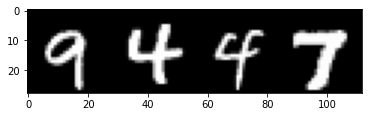

Val:  9447 Modulo:  9 Out:  tensor([9], device='cuda:0')


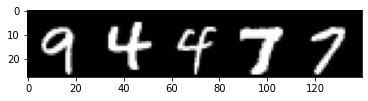

Val:  94477 Modulo:  6 Out:  tensor([6], device='cuda:0')


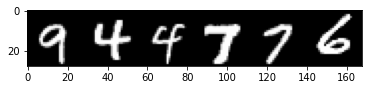

Val:  944776 Modulo:  1 Out:  tensor([1], device='cuda:0')


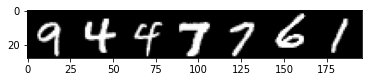

Val:  9447761 Modulo:  11 Out:  tensor([11], device='cuda:0')


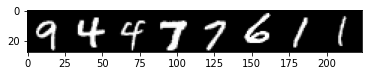

Val:  94477611 Modulo:  7 Out:  tensor([7], device='cuda:0')


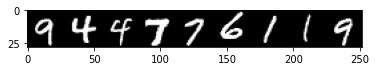

Val:  944776119 Modulo:  1 Out:  tensor([1], device='cuda:0')


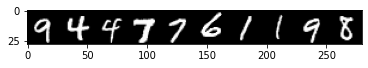

Val:  9447761198 Modulo:  5 Out:  tensor([5], device='cuda:0')


## Úloha 2 - Stratová funkcia len na konci

Teraz vyskúšame trénovanie tak, že chybu budeme počítať len z konca celej sekvencie.

![alt text](https://raw.githubusercontent.com/kocurvik/edu/master/HUPV/supplementary/ntb_images/GRU_single_loss.png)

Doimplemntujte trénovací cyklus. Môžete kľudne skopírovať predchádzajúci kód a upraviť ho.

Tento prístup vám s najväčšou pravdepodobnosťou nebude fungovať a s najväčšou pravdebodobnosťou sa vôbec nenatrénuje.

ConvGRUNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru): GRU(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=13, bias=True)
)
Loss at epoch: 0 step 0: 2.7175660133361816
Loss at epoch: 0 step 100: 2.604506731033325
Loss at epoch: 0 step 200: 2.686643362045288
Loss at epoch: 0 step 300: 2.6347572803497314
Loss at epoch: 0

## Úloha 3 - Variabilná dĺžka vstupu

Teraz si skúsime rovnaký prístup ale vždy na vstupe budeme mať pre každý batch inú dĺžku. Momentálne si to implementujte tak, že použijeme existujúci generátor s nejakom maximálnou dĺžkou a zo sekvencie si potom zoberieme len náhodný počet prvých prvkov.

Samozrejme dalo by sa to spraviť aj elegantnejšie, ale to je komplikovanejšie. Taktiež by bolo možné napríklad upraviť batch size tak aby sme pri kratších sekvenciách mali väčšie batche a naopak aby sme naplno využili pamäť.

Napíšte dole kód a vyskúšajte si trénovanie s loss pre všetky prvky ak bude v každom trénovacom kroku variabilný dĺžka trénovania.

ConvGRUNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru): GRU(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=13, bias=True)
)
Loss at epoch: 0 step 0: 2.7278189659118652
Loss at epoch: 0 step 100: 2.261827230453491
Loss at epoch: 0 step 200: 2.4716415405273438
Loss at epoch: 0 step 300: 2.5562984943389893
Loss at epoch: 